Goals: visualize class counts, top/bottom classes (with thumbnails), and motion maps (frame-diff energy).

Concept overview

Why motion visualization matters

It confirms that your cropping kept enough temporal consistency (the signer doesn’t jump in/out of frame).

It lets you tune parameters like ROI margin or FPS before training.

What you’ll measure

Optical flow magnitude → How strong movement is across frames.

Flow orientation → Direction of motion (e.g., hand up/down).

Temporal variance → Pixel intensity change over time (can proxy for signing activity).

Typical use-cases

Spot-check a few random clips per label.

Compare motion intensity distributions across classes (signs that involve more vs. less movement).

Later, these features can also be used to design attention mechanisms or motion-guided sampling.

### CEll A Imports and Setup

In [2]:
# === Cell A — Setup & Imports ===
import os, random, cv2, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from tqdm.auto import tqdm

root = Path("..").resolve()
data_dir = root / "data" / "wlasl_preprocessed"
roi_dir  = data_dir / "videos_roi"
manifest_path = data_dir / "manifest_nslt2000_roi_final.csv"

assert manifest_path.exists(), "manifest_nslt2000_roi_final.csv not found — run ROI step first."
df = pd.read_csv(manifest_path)
print(f"Loaded manifest with {len(df)} samples, {df['gloss'].nunique()} classes.")
print(f"ROI folder contains {len(list(roi_dir.glob('*.mp4')))} mp4 files.")

# Pick random subset for visualization
SAMPLES = min(8, len(df))
sample_df = df.sample(SAMPLES, random_state=42).reset_index(drop=True)
sample_df.head()


Loaded manifest with 11980 samples, 2000 classes.
ROI folder contains 11980 mp4 files.


video_id                                               path      gloss  \
0     45575  /home/falasoul/notebooks/USD/AAI-590/Capstone/...    puzzled   
1     53255  /home/falasoul/notebooks/USD/AAI-590/Capstone/...  somewhere   
2     27874  /home/falasoul/notebooks/USD/AAI-590/Capstone/...      honor   
3     30386  /home/falasoul/notebooks/USD/AAI-590/Capstone/...  introduce   
4     39443  /home/falasoul/notebooks/USD/AAI-590/Capstone/...        off   

   label  split  
0   1385  train  
1   1633  train  
2    878  train  
3    938  train  
4   1194  train

## Visualize Frame Sequence for Random Samples

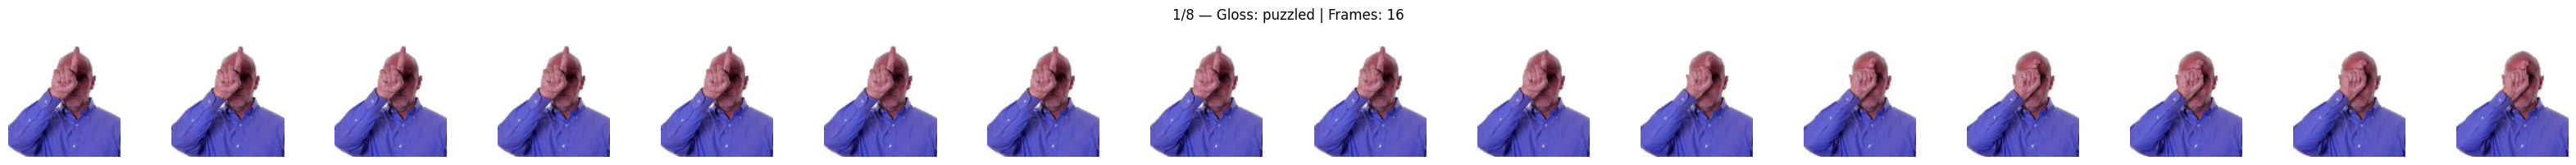

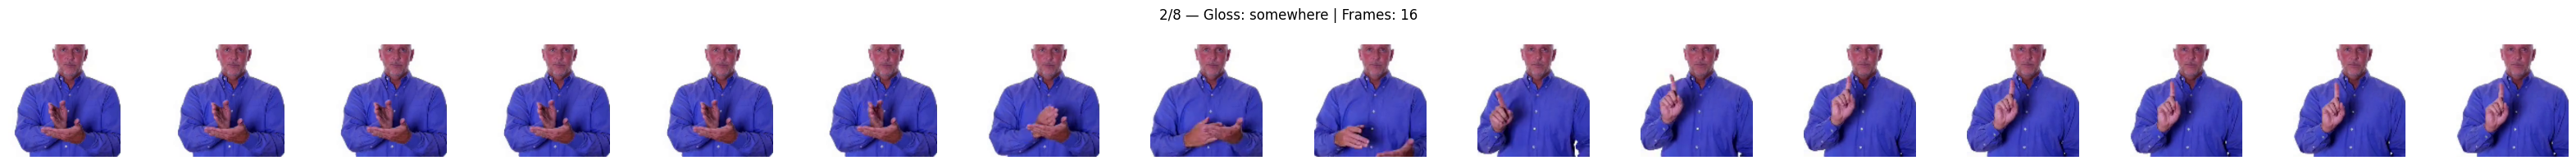

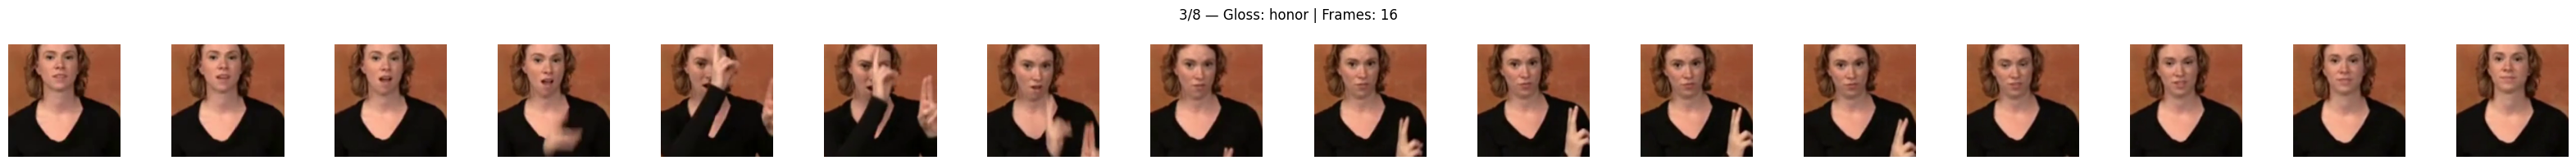

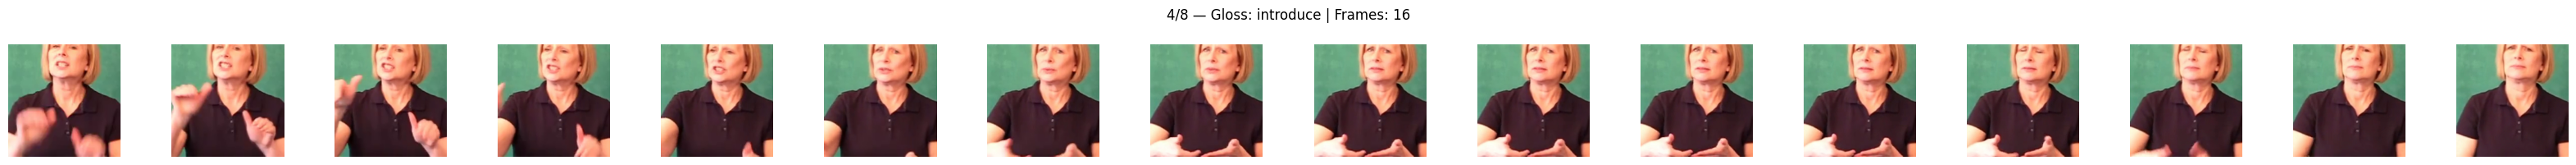

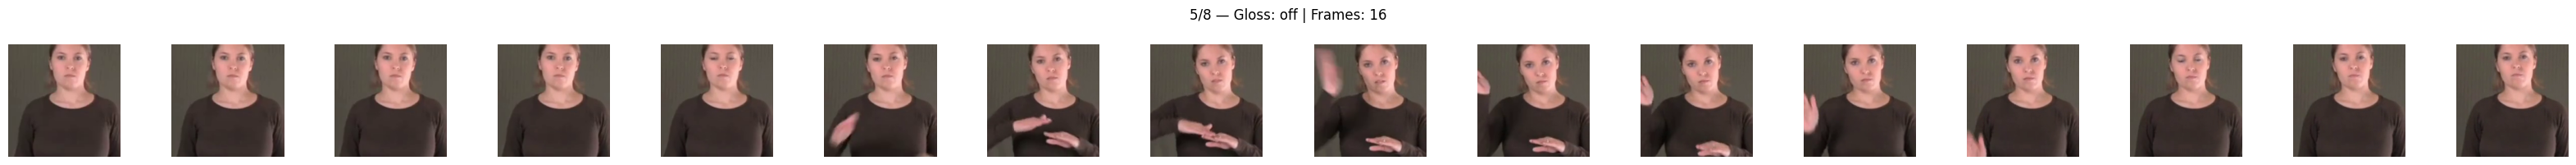

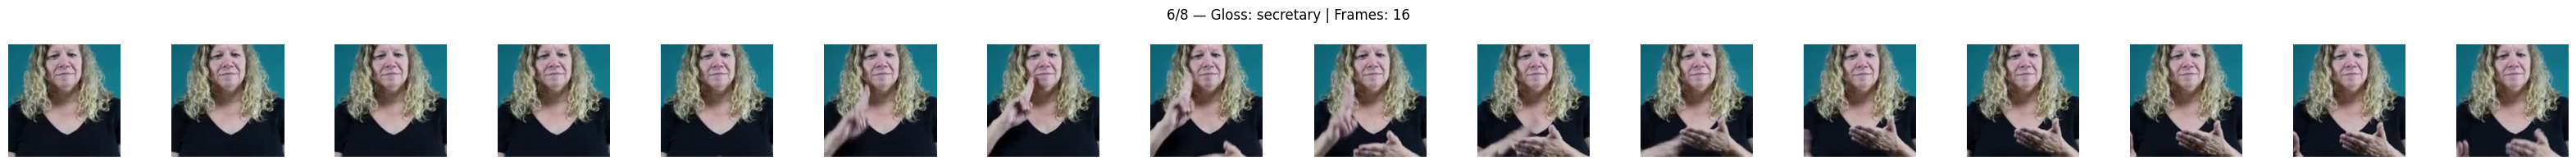

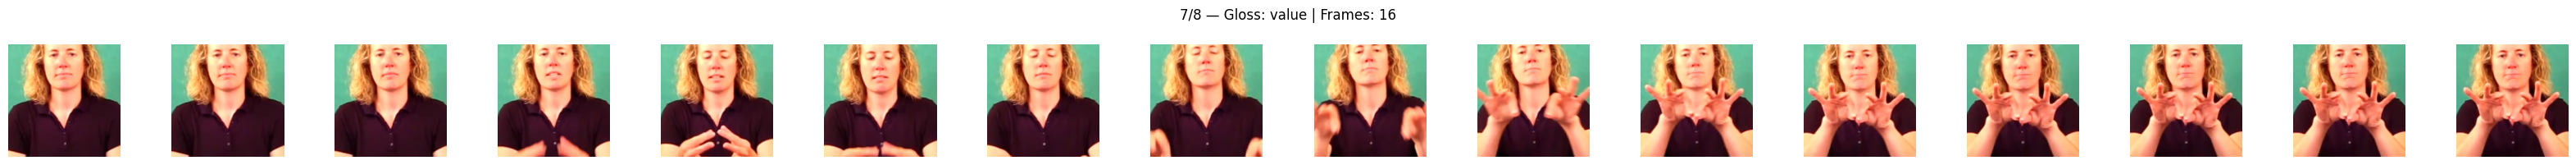

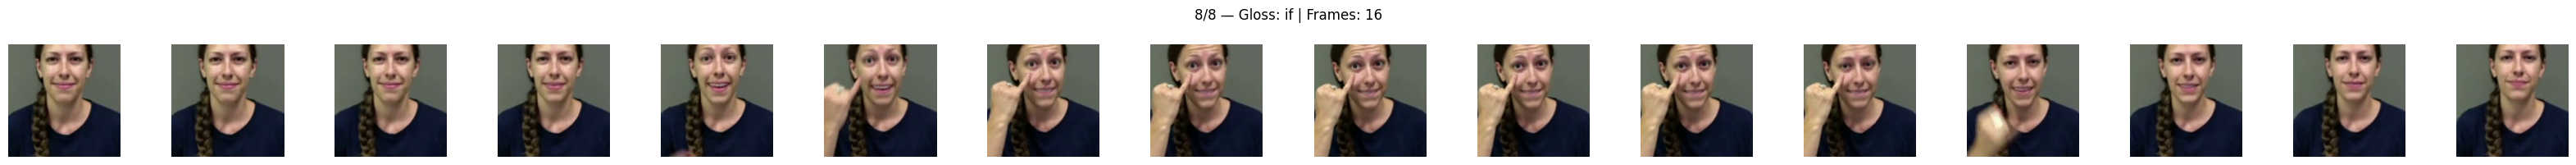

In [3]:
# === Cell B — Visualize Frame Sequence for Random Samples ===
def read_frames(path, max_frames=16):
    cap = cv2.VideoCapture(str(path))
    frames = []
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    step = max(1, total // max_frames)
    idx = 0
    while True:
        ok, frame = cap.read()
        if not ok: break
        if idx % step == 0:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
        idx += 1
    cap.release()
    return frames[:max_frames]

for i, row in sample_df.iterrows():
    frames = read_frames(row["path"])
    n = len(frames)
    if n == 0:
        print(f"⚠️ Cannot read {row['path']}")
        continue
    fig, axs = plt.subplots(1, n, figsize=(n*2, 2))
    for j, f in enumerate(frames):
        axs[j].imshow(f)
        axs[j].axis("off")
    plt.suptitle(f"{i+1}/{SAMPLES} — Gloss: {row['gloss']} | Frames: {n}")
    plt.tight_layout()
    plt.show()


### Cell C — Dense Optical Flow Visualization (Farnebäck)

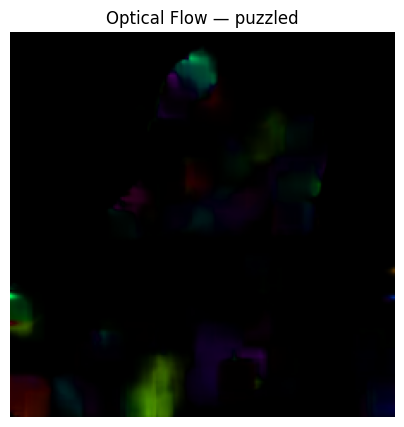

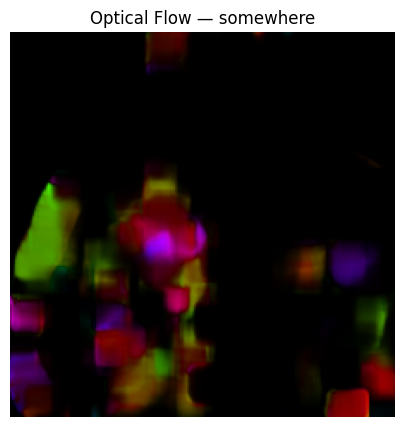

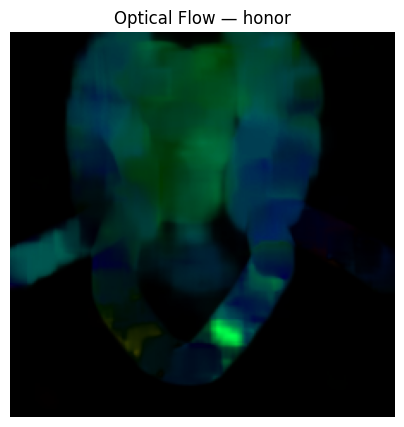

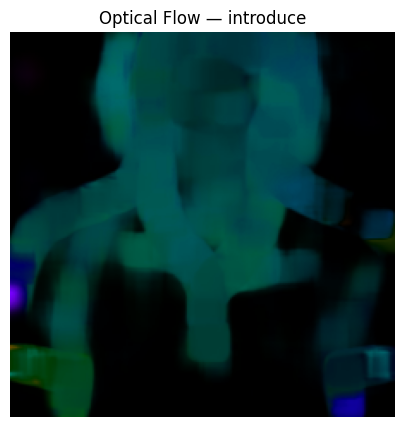

In [4]:
# === Cell C — Dense Optical Flow Visualization (Farnebäck) ===
def optical_flow_preview(video_path, every=2):
    cap = cv2.VideoCapture(str(video_path))
    ret, prev = cap.read()
    if not ret:
        return None
    prev_gray = cv2.cvtColor(prev, cv2.COLOR_BGR2GRAY)
    flow_vis = np.zeros_like(prev)
    frame_count = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_count % every == 0:
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            flow = cv2.calcOpticalFlowFarneback(prev_gray, gray,
                                                None, 0.5, 3, 15, 3, 5, 1.2, 0)
            mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
            hsv = np.zeros_like(frame)
            hsv[..., 1] = 255
            hsv[..., 0] = ang * 180 / np.pi / 2
            hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
            flow_vis = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
            prev_gray = gray
        frame_count += 1
    cap.release()
    return flow_vis

S = 4
for i, row in sample_df.head(S).iterrows():
    flow_img = optical_flow_preview(row["path"])
    if flow_img is None:
        continue
    plt.figure(figsize=(5, 5))
    plt.imshow(flow_img)
    plt.axis("off")
    plt.title(f"Optical Flow — {row['gloss']}")
    plt.show()


### Cell D — Temporal Difference Heatmap

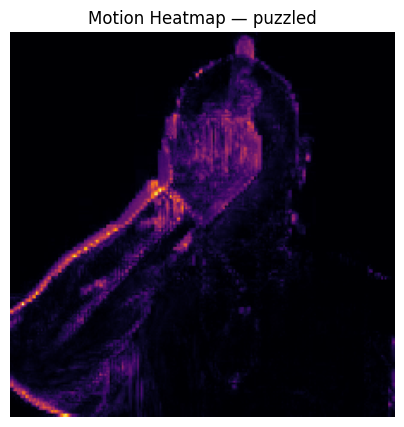

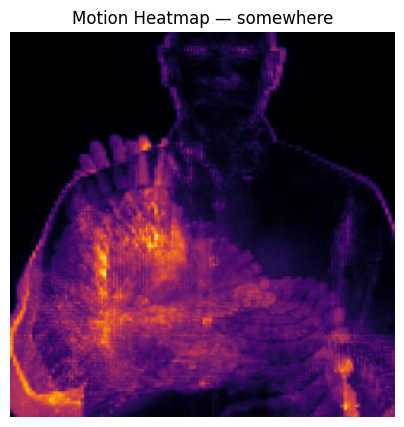

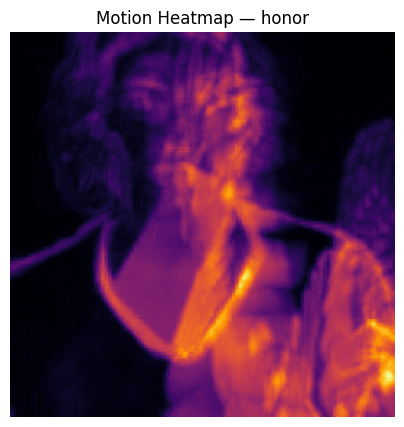

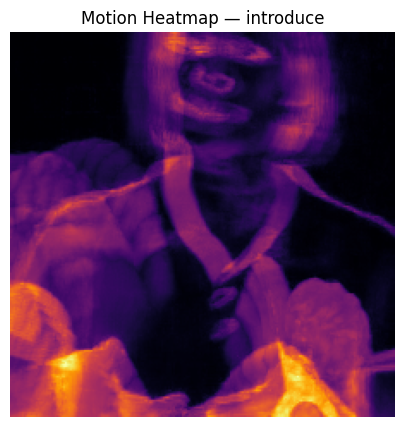

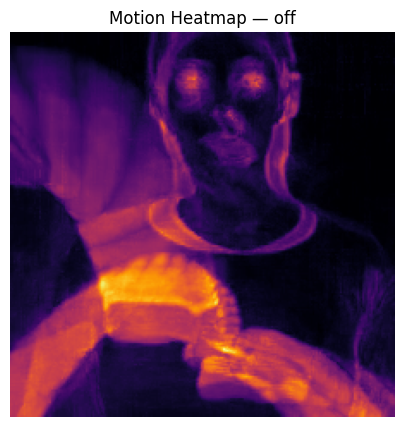

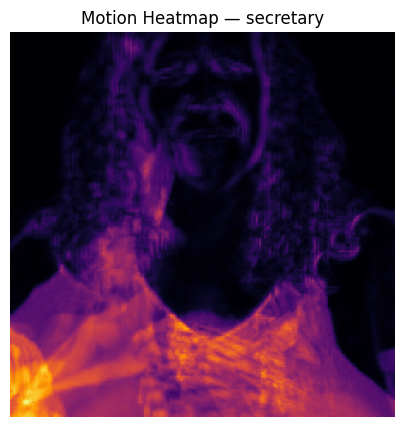

In [5]:
# === Cell D — Temporal Difference Heatmap ===
def motion_heatmap(video_path, max_frames=50):
    cap = cv2.VideoCapture(str(video_path))
    ret, prev = cap.read()
    if not ret:
        return None
    prev_gray = cv2.cvtColor(prev, cv2.COLOR_BGR2GRAY)
    acc = np.zeros_like(prev_gray, dtype=np.float32)
    count = 0
    while True:
        ret, frame = cap.read()
        if not ret or count > max_frames:
            break
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        diff = cv2.absdiff(prev_gray, gray)
        acc += diff
        prev_gray = gray
        count += 1
    cap.release()
    acc = cv2.normalize(acc, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    return acc

for i, row in sample_df.head(6).iterrows():
    heat = motion_heatmap(row["path"])
    if heat is None:
        continue
    plt.figure(figsize=(5, 5))
    plt.imshow(heat, cmap="inferno")
    plt.axis("off")
    plt.title(f"Motion Heatmap — {row['gloss']}")
    plt.show()


#### Cell E — Per-Clip Motion Summary (Quantitative)

Computing motion stats: 0it [00:00, ?it/s]

[mov,mp4,m4a,3gp,3g2,mj2 @ 0x59c98d9d1b00] moov atom not found
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x59c98d9d1b00] moov atom not found
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x7e73140b40c0] moov atom not found
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x7e72fc045ec0] moov atom not found


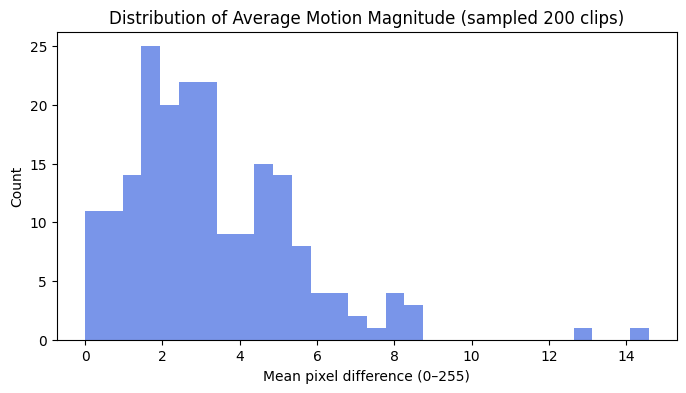

In [6]:
def motion_score(video_path, max_frames=40):
    cap = cv2.VideoCapture(str(video_path))
    ret, prev = cap.read()
    if not ret: 
        return 0.0
    prev_gray = cv2.cvtColor(prev, cv2.COLOR_BGR2GRAY)
    scores = []
    count = 0
    while True:
        ret, frame = cap.read()
        if not ret or count > max_frames:
            break
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        diff = cv2.absdiff(prev_gray, gray)
        scores.append(diff.mean())
        prev_gray = gray
        count += 1
    cap.release()
    return np.mean(scores) if scores else 0.0

motion_vals = []
for row in tqdm(df.sample(min(200, len(df))).itertuples(index=False), desc="Computing motion stats"):
    score = motion_score(row.path)
    motion_vals.append(score)

plt.figure(figsize=(8, 4))
plt.hist(motion_vals, bins=30, color="royalblue", alpha=0.7)
plt.title("Distribution of Average Motion Magnitude (sampled 200 clips)")
plt.xlabel("Mean pixel difference (0–255)")
plt.ylabel("Count")
plt.show()

### Cell F — Optional: Pose Overlay Preview (Quick QA)

I0000 00:00:1762896092.444706 2032822 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1762896092.471868 1344797 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 575.64.03), renderer: NVIDIA GeForce RTX 5080/PCIe/SSE2
W0000 00:00:1762896092.512480 1344786 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762896092.515977 1344776 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


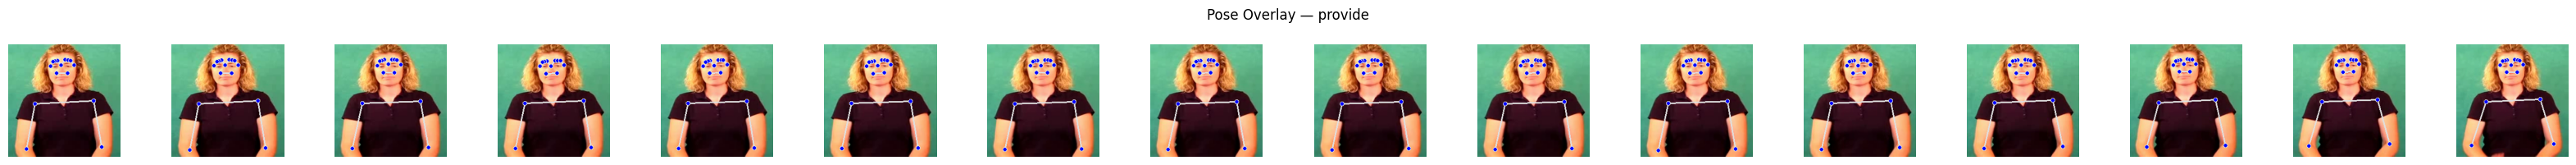

In [ ]:
# === Cell F — Optional: Pose Overlay Preview (Quick QA) ===
import mediapipe as mp
mp_pose = mp.solutions.pose

def pose_overlay(video_path, max_frames=16):
    cap = cv2.VideoCapture(str(video_path))
    pose = mp_pose.Pose(static_image_mode=True, model_complexity=0)
    frames = []
    count = 0
    while True:
        ret, frame = cap.read()
        if not ret or count >= max_frames:
            break
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        res = pose.process(rgb)
        if res.pose_landmarks:
            mp.solutions.drawing_utils.draw_landmarks(
                rgb, res.pose_landmarks, mp_pose.POSE_CONNECTIONS)
        frames.append(rgb)
        count += 1
    pose.close()
    cap.release()
    return frames

frames = pose_overlay(sample_df.iloc[0]["path"])
fig, axs = plt.subplots(1, len(frames), figsize=(len(frames)*2, 2))
for i, f in enumerate(frames):
    axs[i].imshow(f)
    axs[i].axis("off")
plt.suptitle(f"Pose Overlay — {sample_df.iloc[0]['gloss']}")
plt.tight_layout()
plt.show()
